In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import torchaudio.transforms as transforms
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pyaudio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#IPython audio playback function
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

cuda


AudioMetaData(sample_rate=22050, num_frames=16128, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Number of Channels: 1
Number of Frames  : 16128
Sample Rate       : 22050


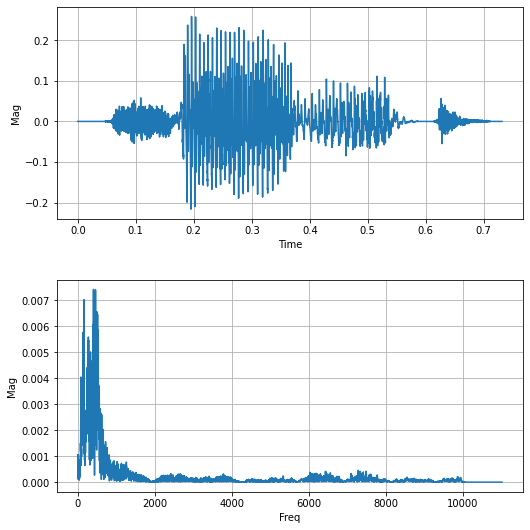

In [2]:
# Check that we can play one of our audio samples
print(torchaudio.info("data/audio_keyword_recognition/forward/1.wav"))
waveform, sample_rate = torchaudio.load("data/audio_keyword_recognition/forward/1.wav")

play_audio(waveform, sample_rate)

#Getting key parameters
num_channels, num_frames = waveform.shape

print("Number of Channels: " + str(num_channels))
print("Number of Frames  : " + str(num_frames))
print("Sample Rate       : " + str(sample_rate))

#Getting the variables required to plot the waveform

waveform_np = waveform.numpy().reshape(-1,)
time_axis = np.arange(0,num_frames) / sample_rate

# Generating the Fourier Transform

# sample spacing
T = 1.0 / sample_rate

xf = fftfreq(num_frames, T)[:num_frames//2]
yf = 2.0/num_frames * np.abs(fft(waveform_np)[0:num_frames//2])

#Plotting Waveform and Fourier Transform
fig, axs = plt.subplots(2,figsize=(8,8))
axs[0].plot(time_axis, waveform_np)
axs[0].grid()
axs[1].plot(xf, yf)
axs[1].grid()

x=0
for ax in axs.flat:
    if x == 0:
        ax.set(xlabel='Time', ylabel='Mag')
    else:
        ax.set(xlabel='Freq', ylabel='Mag')
        
    x+=1
    
fig.tight_layout(pad=3.0)
plt.show()

#print(len(time_axis))
#print(time_axis[1]-time_axis[0])
#print(1/sample_rate)

In [3]:
#Loading the data from our folder
data_folder = "data/audio_keyword_recognition/"

num_ambient = 5
num_commands = 20

waveform_list = []
sample_rate_list = []
class_list = []

#Load data for foreward
foreward_folder = data_folder + str("forward/")

#I only have 10 wav files per class in each folder
#We use 0 to denote the class for "foreward" and 1 to denote the class for "backward"
for i in range(10):
    file_path = foreward_folder + str(i+1) + ".wav"
    waveform, sample_rate = torchaudio.load(file_path)
    waveform_list.append(waveform)
    sample_rate_list.append(sample_rate)
    class_list.append(int(1))
    
#Load data for backward
backward_folder = data_folder + str("backward/")

for i in range(10):
    file_path = backward_folder + str(i+1) + ".wav"
    waveform, sample_rate = torchaudio.load(file_path)
    waveform_list.append(waveform)
    sample_rate_list.append(sample_rate)
    class_list.append(int(2))

#Load data for ambient
folder_path = data_folder + str("ambient/")

ambient_waveform_list = []

for i in range(num_ambient):
    file_path = folder_path + str(i+1) + ".wav"
    waveform, sample_rate = torchaudio.load(file_path)
    #Resampling everything to the same rate of 22050
    transform = transforms.Resample(sample_rate, 22050)
    waveform = transform(waveform)
    #Combining the 2 channels
    waveform = ((waveform[0]+waveform[1]) / 2).view(1,-1)
    ambient_waveform_list.append(waveform)

In [4]:
# We want to generate a list of 100 samples, with random background noise and the voice command randomly truncated up to half
# Also, all samples will be exactly 22050 elements or 1 sec long
# Since the x-axis vector of the fourier transform depends on the sample_rate and the num_frames, 
# as long as we resample everything to the same rate and ensure that they are all the same length (same number of frames),
# we can safely ignore this x-axis vector as they will all be the same
# then we just retain the y-axis vector as our feature

sample_list = []
label_list = []
elements_wanted = 22050

for i in range(100):
    
    #We want to get a random vector of 22050 elements from the ambient waveform list for 1 sec of random background audio
    random_ambient_index = np.random.randint(0, num_ambient)
    ambient_waveform_np = ambient_waveform_list[random_ambient_index].numpy().reshape(-1,)
    last_start_element = len(ambient_waveform_np)-elements_wanted+1
    start = np.random.randint(0,last_start_element)
    ambient_1s_waveform = ambient_waveform_np[start:start+elements_wanted]

    #We want to crop the waveform such that at max we cut out half the voice command
    random_waveform_index = np.random.randint(0, num_commands)
    waveform_np = waveform_list[random_waveform_index].numpy().reshape(-1,)

    num_frames = len(waveform_np) 
    max_start = int(num_frames / 2)
    min_start = max_start - 22050

    start = np.random.randint(min_start, max_start)
    end = start + 22050

    if end <= num_frames:
        #print("truncate_back")
        waveform_np=waveform_np[0:end]
        #print(len(waveform_np))
        waveform_np=np.pad(waveform_np, (22050-len(waveform_np),0), constant_values=(0,0))
        #print(len(waveform_np))

    elif start <= 0 and end >= num_frames:
        #print("middle")
        waveform_np=np.pad(waveform_np, (-start,end-num_frames), constant_values=(0,0))
        #print(waveform_np.shape)

    else:
        #print("truncate_front")
        waveform_np=waveform_np[start:num_frames]
        #print(len(waveform_np))
        waveform_np=np.pad(waveform_np, (0,22050-len(waveform_np)), constant_values=(0,0))
        #print(len(waveform_np))

    #print(ambient_1s_waveform.shape)
    #print(waveform_np.shape)

    #Scaling the ambient sound waveform by 0.2 as it was too loud
    sample_list.append(ambient_1s_waveform * 0.2 + waveform_np)
    label_list.append(class_list[random_waveform_index])

#Generate some samples with just background noise as class 0
for i in range(50):
    random_ambient_index = np.random.randint(0, num_ambient)
    ambient_waveform_np = ambient_waveform_list[random_ambient_index].numpy().reshape(-1,)
    last_start_element = len(ambient_waveform_np)-elements_wanted+1
    start = np.random.randint(0,last_start_element)
    sample_list.append(ambient_1s_waveform)
    label_list.append(0)

In [83]:
#Play back random samples to check
#0 for ambient, 1 for foreward, 2 for backward
random_sample=np.random.randint(0, 150)
play_audio(torch.tensor(sample_list[random_sample]).view(1,-1), 22050)
classes = ['ambient','forwards','backwards']
print(classes[label_list[random_sample]])

forwards


In [10]:
#Calculate fourier transform for all samples

X=[]
max_frames = 22050

for i in range(len(sample_list)):
    waveform_np = sample_list[i]
    X.append(2.0/max_frames * np.abs(fft(waveform_np)[0:max_frames//2]))

print("Fourier Transform computation done")

#Using Sci-Kit Learn to do the train-test split and standard scaling
X = np.array(X)
y = np.array(label_list)

#one hot encode for the label
n_values = np.max(y) + 1
y=np.eye(n_values)[y]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

#print(X_train.shape)
#print(X_test.shape)
#print(X_val.shape)
#print(y_train)
#print(y_test)
#print(y_val)

# Remember to do any scaling after the train-test-val split to avoid data leakage from the test/val sets to the train set.
# We do not need to do a standard scaler here since all the samples are on the same scale already, which is taken care of by the FFT

#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train=scaler.transform(X_train)
#X_test=scaler.transform(X_test)
#X_val=scaler.transform(X_val)
print("Train Test Val Split done")

# Converting everything to tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
y_val = torch.tensor(y_val).float()

Fourier Transform computation done
Train Test Val Split done


In [73]:
#Define the Neural Network

size = 32

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(11025, size)
        self.fc2=nn.Linear(size, size)
        self.fc3=nn.Linear(size, 3)
        #self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        #print(x.shape)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [74]:
#Reset Neural Network Instance
net=Net()
print(net)
params = list(net.parameters())
print(len(params))
print(params[0].size())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
#optimizer = torch.optim.SGD(net.parameters(),lr=1)

#variables that need to be reset for the first time training
min_val_loss = math.inf
val_loss_hist=[]
loss_hist=[]
epoch = 0

Net(
  (fc1): Linear(in_features=11025, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)
6
torch.Size([32, 11025])


Training Started: Full Batch Gradient Descent
Epoch: 10. Train Loss: 0.01206752724117703. Val Loss: 0.03598326841990153
Epoch: 20. Train Loss: 0.01189600494172838. Val Loss: 0.03543800910313924
Epoch: 30. Train Loss: 0.011580395698547363. Val Loss: 0.03448867003122966
Epoch: 40. Train Loss: 0.011064761877059936. Val Loss: 0.03291259407997131
Epoch: 50. Train Loss: 0.010244804620742797. Val Loss: 0.030431675910949706
Epoch: 60. Train Loss: 0.009228814310497708. Val Loss: 0.027391705910364786
Epoch: 70. Train Loss: 0.008157511552174887. Val Loss: 0.02419432600339254
Epoch: 80. Train Loss: 0.007172881894641452. Val Loss: 0.02135080297787984
Epoch: 90. Train Loss: 0.006413123342725965. Val Loss: 0.019134461879730225
Epoch: 100. Train Loss: 0.005892679426405165. Val Loss: 0.017612775166829426
Epoch: 110. Train Loss: 0.005541083216667175. Val Loss: 0.01657275060812632
Epoch: 120. Train Loss: 0.005272875560654534. Val Loss: 0.015772297978401184
Epoch: 130. Train Loss: 0.005031821793980069. Va

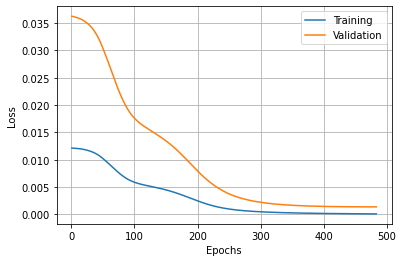

[2 0 1 1 2 1 2 2 0 1 0 0 0 1 2 2 2 1 2 0 2 0 1 0 0 1 1 2 0 2]
[2 0 1 1 2 1 2 2 0 1 0 0 0 1 2 2 2 1 2 0 2 0 1 0 0 1 1 2 0 2]
Test Accuracy: 1.0


In [75]:
# Using full batch gradient descent because we do not have that much data and all can go into memory.
# Not using cuda as well due to small network which trains quickly on CPU.

print("Training Started: Full Batch Gradient Descent")

patience = 0

for _ in range(500):
    
    epoch += 1
        
    net.train()
    optimizer.zero_grad()   # zero the gradient buffers
    
    output = net.forward(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()    # Does the update
    train_loss = loss.item() / len(X_train)
    loss_hist.append(train_loss) 
    
    net.eval()
    output = net.forward(X_val)
    loss = criterion(output, y_val)
    val_loss = loss.item() / len(X_val)
    val_loss_hist.append(val_loss) 
    
    if epoch % 10 == 0:
        print("Epoch: " + str(epoch) + ". Train Loss: " + str(train_loss) + ". Val Loss: " + str(val_loss))
    
    # 2 Conditions for early stopping:
    #     1) if training loss reaches 0
    #     2) if validation loss is increasing for 3 epochs
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(net.state_dict(), "torchmodel/weights_best.pth")
        #print('\033[93m'+"Model Saved"+'\033[0m')
        patience = 0
        
    else:
        patience += 1
    
    if (patience == 3 or train_loss == 0):
        break
    
print("Training Ended")

torch.save(net.state_dict(), "torchmodel/weights_latest.pth")

# Printing loss history 
epoch_list=np.arange(1,len(loss_hist)+1)

plt.plot(epoch_list,loss_hist)
plt.plot(epoch_list,val_loss_hist)
plt.legend(['Training','Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Perfoming accuracy check on test set
softmax = nn.Softmax(dim=1)
net.load_state_dict(torch.load("torchmodel/weights_best.pth"))
net.eval()
output = softmax(net.forward(X_test))
output = torch.argmax(output, dim=1).detach().numpy()
y_test_argmax = torch.argmax(y_test, dim=1).numpy()
print(output)
print(y_test_argmax)
test_accuracy = sum(output == y_test_argmax) / len(output)
print("Test Accuracy: " + str(test_accuracy))

In [76]:
# Testing the classifier on our own voice
# Using PyAudio to record

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 22050
RECORD_SECONDS = 1

p = pyaudio.PyAudio()

In [80]:
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

recorded = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    decoded = np.frombuffer(data, dtype=np.int16)
    recorded = np.concatenate((recorded,decoded))

print("* done recording")

stream.stop_stream()
stream.close()
#p.terminate()

#plt.plot(recorded)
recorded_torch = torch.from_numpy(recorded.reshape(1,-1))
play_audio(recorded_torch, RATE)

max_frames = 22050

sample = 2.0/max_frames * np.abs(fft(recorded)[0:max_frames//2])
#sample=scaler.transform(sample.reshape(1,-1))
sample=torch.tensor(sample.reshape(1,-1)).float()

# Perfoming accuracy check on test set
softmax = nn.Softmax(dim=1)

net=Net()
net.load_state_dict(torch.load("torchmodel/weights_best.pth"))
net

net.eval()
output = softmax(net.forward(sample))
print(output)
output = torch.argmax(output, dim=1).detach().numpy()[0]
classes = ['ambient','forward','backward']
print(classes[output])

* recording
* done recording


tensor([[1., 0., 0.]], grad_fn=<SoftmaxBackward0>)
ambient


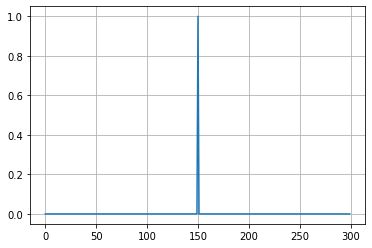

In [31]:
# Everything below is just for learning / testing purposes.

# Learning how scipy FFT works
# Generating the function to perform the fft on
# Function is sin(omega * t), where omega = 2 * pi * freq
# If we change the frequency, 
# We should see a corresponding spike on the FFT at that frequency
# Code reference: https://docs.scipy.org/doc/scipy/tutorial/fft.html

from scipy.fft import fft, fftfreq
import numpy as np

# Generating the sine function
f=150.0
w=2.0*np.pi*f

# Number of sample points
N = 600
# sample spacing
T = 1.0 / N

x = np.linspace(0.0, N*T, N, endpoint=False)

#print(len(x))

y=[]
for i in range(len(x)):
    y.append(np.sin(w*x[i]))

y=np.array(y)

# Generating the Fourier Transform
xf = fftfreq(N, T)[:N//2]
yf = 2.0/N * np.abs(fft(y)[0:N//2])

import matplotlib.pyplot as plt
plt.plot(xf, yf)
plt.grid()
plt.show()

In [32]:
#Testing of Zero Padding
a = [1, 2, 3, 4, 5]
number_of_pads = 10 - len(a)
a=np.pad(a, (0,number_of_pads), constant_values=(0,0))
print(a)
print(len(a))

[1 2 3 4 5 0 0 0 0 0]
10
